### Prueba básica del API

Lo primero que se realiza es que el API de Gemini esté funcionando de manera correcta. También se puede verificar cuales modelos se encuentran disponibles actualmente

In [18]:
from google import genai
from dotenv import load_dotenv
import os

load_dotenv()
client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

# List models
for m in client.models.list():
    print(m.name)


models/embedding-gecko-001
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-05-20
models/gemini-2.5-flash
models/gemini-2.5-flash-lite-preview-06-17
models/gemini-2.5-pro-preview-05-06
models/gemini-2.5-pro-preview-06-05
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/learnlm-2.0-flash-experimental
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
mo

# Prueba básica de agente
Ahora pasaremos a realizar una prueba básica de la lógica del agente, en la se estará utilizando la terminal para realizar las pruebas, en el output de la celda de jupyter se podrá observar en forma de Stream lo que responde la IA, lo que responde el Humano y los Tools que se llaman. 

In [19]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage, HumanMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
import sqlite3

# Exportamos las variables de entorno
load_dotenv()

# Se carga el API key
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

# Creamos el estado del agente
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [20]:
# Tools de Agente
@tool
def query_tool(query: str):
    """Herramienta para hacer consultas a la base de datos, la información que acepta el tool es un SQL query
    La estructura de la tabla llamada ventas es la siguiente:
    id INTEGER PRIMARY KEY,
    producto TEXT NOT NULL,
    categoria TEXT NOT NULL,
    precio REAL NOT NULL,
    pais TEXT NOT NULL,
    fecha_venta DATE NOT NULL
    """
    # Se conecta a la base de datos
    conn = sqlite3.connect('ventas.db')
    cursor = conn.cursor()
    
    # Ejectuta el query realizado por el agente
    cursor.execute(query)
    rows = cursor.fetchall()

    return rows

# Se crea la lista de tools
tools = [query_tool]

# Se crea el modelo de LLM y se asocian los tools
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    temperature=0,
    verbose=True,
).bind_tools(tools)

In [21]:
# Nodos de Agente

'''
El contexto de la empresqa es el siguiente:

La empresa TechNova vende productos electrónicos. Tiene un promedio de 5.000
ventas mensuales en Latinoamérica. Sus categorías principales son smartphones,
notebooks y accesorios.

'''

# Nodo que llama al agente
def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content=(
            "Eres un asistente con acceso a un tool para hacer consultas SQL sobre la base 'ventas'. "
            "Usa el tool cuando necesites datos y luego responde al usuario con un resumen claro. "
            "Si el tool devuelve JSON, interprétalo y explica el resultado."
            "También puedes responder información sobre la empresa TechNova"
            "La empresa TechNova vende productos electrónicos. Tiene un promedio de 5.000 ventas mensuales en Latinoamérica."
            "Sus categorías principales son smartphones, notebooks y accesorios."
            
        )
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

# Nodo para ver si se finaliza el contexto
def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"

In [22]:
# Estructura del graph

# Estado
graph = StateGraph(AgentState)

# Nodos
graph.add_node("our_agent", model_call)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

# Edgees
graph.set_entry_point("our_agent")
graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)
graph.add_edge("tools", "our_agent")

# Se compila el graph
app = graph.compile()


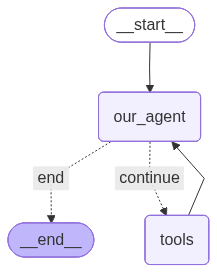

In [23]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [24]:
# Función para visualizar de mejor manera los resultados
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
            
# Prueba de una sola pregunta
#input_user = input("Enter: ")
#inputs = {"messages": [HumanMessage(content=input_user)]}  # <-- HumanMessage
#print_stream(app.stream(inputs, stream_mode="values"))

# Prueba en Loop

# Se pide por primera vez la preegunta al user
input_user = input("Enter: ")
while input_user != "exit":
    # Se realiza la pregunta al agente
    inputs = {"messages": [(input_user)]}
    # Se muestra la respuesta
    print_stream(app.stream(inputs, stream_mode="values"))
    # Se repite el ciclo con el user preguntando
    input_user = input("Enter: ")


================================ Human Message =================================

¿Cuál fue el precio promedio de venta en Chile?
================================== Ai Message ==================================
Tool Calls:
  query_tool (c5ad4ea2-23f0-4503-90fa-584f5ea7dc52)
 Call ID: c5ad4ea2-23f0-4503-90fa-584f5ea7dc52
  Args:
    query: SELECT AVG(precio) FROM ventas WHERE pais = "Chile"
================================= Tool Message =================================
Name: query_tool

[[1800.0]]
================================== Ai Message ==================================

El precio promedio de venta en Chile fue de 1800.


## Prueba del API

Ya teniendo el API corriendo, en esta sección se podrán realizar diferentes pruebas para observar si funciona de manera correcta el EndPoint. 

In [ ]:
# Prueba del API local
import requests
import os
from dotenv import load_dotenv  

API_URL = "http://127.0.0.1:8000/ask"
API_KEY = os.getenv('API_KEY')
load_dotenv()

# Pregunta de prueba (puedes cambiarla)
payload = {
    "question": "¿Cuál fue el precio promedio de venta en Chile?"
}

headers = {
    "Content-Type": "application/json",
    "X-API-Key": API_KEY  # Add the API key header
}

response = requests.post(API_URL, json=payload, headers=headers)

print("Status code:", response.status_code)

print("Response JSON:")
print(response.json())

Status code: 200
Response JSON:
{'final_answer': 'El precio promedio de venta en Chile fue de 1800.', 'tool_calls': [{'tool_name': 'query_tool', 'arguments': {'query': "SELECT AVG(precio) FROM ventas WHERE pais = 'Chile'"}}], 'result': {'columns': ['AVG(precio)'], 'rows': [{'AVG(precio)': 1800.0}], 'executed_sql': "SELECT AVG(precio) FROM ventas WHERE pais = 'Chile'"}}


In [ ]:
# Prueba del API en producción
import requests
import os
from dotenv import load_dotenv  

API_URL = "https://atomrepo-production.up.railway.app/ask"
API_KEY = os.getenv('API_KEY')
load_dotenv()

# Pregunta de prueba (puedes cambiarla)
payload = {
    "question": "¿Cuál fue el precio promedio de venta en Chile?"
}

headers = {
    "Content-Type": "application/json",
    "X-API-Key": API_KEY  # Add the API key header
}

response = requests.post(API_URL, json=payload, headers=headers)

print("Status code:", response.status_code)

print("Response JSON:")
print(response.json())